# Two Resistance Mechanism (TRM) method

Notes on how this is working!

Variables needed:  
* Looks good: lambda0, ro, ra, rs, Rnet, delta, qsat_Ta, qa, rho, gamma, 
* No nan, but looks weird: 
    * f
    * delta_rs
    
* OVERESTIMATING CHANGES FROM rs and ra, especially in high lats. Work on getting the albedo vars to look reasonable first.

* SENSITIVITY TO rs in ICE REGIONS DOES NOT MAKE SENSE... SHOULD NOT BE NEGATIVE EVER

Filters currently used:
* SH > 5 (for calculating ra)
* LH > 5 (for calculating rs)
* ra > 0
* rs > 0
* calculated emissivity <=1
* Tdiff = Ts-Ta > 0 (for calculating ra)
* qdiff = qsat_Ts - qa > 0 (for calculating rs)
* delta_rs <=1000

# Set up workspace

In [63]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from scipy import stats
import pandas as pd

In [64]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils/')
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/analyze_simulations/offline_mechanism/')

In [65]:
from load_ensembles import *

In [66]:
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs

In [67]:
from utils import *

In [68]:
from load_gridcell_areas import *

# Load data from reference simulation

Variables needed:
##### *Atmospheric Inputs*
    * TBOT (Atmospheric temperature: available daily and monthly)
    * QBOT (Atmospheric specific humidity: available daily and monthly)
    * PBOT
    * FSDS (Incoming SW radiation: available daily and monthly)
    * FLDS (Incoming LW radiation: available daily and monthly)
    
##### *Land surface fluxes/state* 
    * EFLX_LH_TOT (Latent heat: available daily and monthly)
    * FSH_TO_COUPLER (Sensible heat: available daily and monthly)
    * Ts
    * FSA (can be calculated from FSR: available daily and monthly)
    * FIRE (Emitted LW radiation: available daily and monthly)
    * FIRA - maybe don't need??

In [69]:
ds=xr.open_dataset('/glade/campaign/univ/uwas0044/czarakas/StomatalSlope2021/coupled_experiments/coupled_DEFmedslope_1xCO2_03/lnd/hist/'+
                   'coupled_DEFmedslope_1xCO2_03.clm2.h0.0061-02-01-00000.nc')

In [70]:
#Tau_all=np.sqrt((ds.TAUX*ds.TAUX)+(ds.TAUY*ds.TAUY))
#rho=1
#ra_est2=(rho*ds.WIND/Tau_all)
#ra_est2_mean=ra_est2.where(ra_est2['time.month']==1).mean(dim='time').load()

In [71]:
#ra_est2_mean.plot(vmin=0, vmax=300)

In [72]:
for i,var in enumerate(ds.variables):
    if i>13:
        print(var)
        print(ds[var].long_name)

lat
coordinate latitude
area
grid cell areas
landfrac
land fraction
landmask
land/ocean mask (0.=ocean and 1.=land)
pftmask
pft real/fake mask (0.=fake and 1.=real)
nbedrock
index of shallowest bedrock layer
ACTUAL_IMMOB
actual N immobilization
AGNPP
aboveground NPP
ALT
current active layer thickness
ALTMAX
maximum annual active layer thickness
ANSHA_LN
shaded leaf net photosynthesis at local noon
ANSUN_LN
sunlit leaf net photosynthesis at local noon
AR
autotrophic respiration (MR + GR)
ATM_TOPO
atmospheric surface height
BAF_CROP
fractional area burned for crop
BAF_PEATF
fractional area burned in peatland
BCDEP
total BC deposition (dry+wet) from atmosphere
BGNPP
belowground NPP
BTRAN2
root zone soil wetness factor
BTRANMN
daily minimum of transpiration beta factor
C13_AR
C13 autotrophic respiration (MR + GR)
C13_GPP
C13 gross primary production
C13_HR
C13 total heterotrophic respiration
C13_NBP
C13 net biome production, includes fire, landuse, harvest and hrv_xsmrpool flux (latter smo

### Load reference data

In [73]:
spin_up_yr=40

In [74]:
### Load reference data
key_ref='OFFL0000_PI_v02'

ds_Ta_ref=get_dataset(ensemble_dir='offline_simulations',var='TBOT', key=key_ref)['TBOT'][spin_up_yr*12:,:,:]
ds_qa_ref=get_dataset(ensemble_dir='offline_simulations',var='QBOT', key=key_ref)['QBOT'][spin_up_yr*12:,:,:]
ds_P_ref=get_dataset(ensemble_dir='offline_simulations',var='PBOT', key=key_ref)['PBOT'][spin_up_yr*12:,:,:]
ds_FSDS_ref=get_dataset(ensemble_dir='offline_simulations',var='FSDS', key=key_ref)['FSDS'][spin_up_yr*12:,:,:]
ds_FLDS_ref=get_dataset(ensemble_dir='offline_simulations',var='FLDS', key=key_ref)['FLDS'][spin_up_yr*12:,:,:]

met_ref=met_driver_data(ds_FSDS_ref, ds_FLDS_ref, ds_Ta_ref, ds_qa_ref, ds_P_ref)

In [75]:
ds_Theta_ref=get_dataset(ensemble_dir='offline_simulations',var='THBOT', key=key_ref)['THBOT'][spin_up_yr*12:,:,:]
ds_TAUx_ref=get_dataset(ensemble_dir='offline_simulations',var='TAUX', key=key_ref)['TAUX'][spin_up_yr*12:,:,:]
ds_TAUy_ref=get_dataset(ensemble_dir='offline_simulations',var='TAUY', key=key_ref)['TAUY'][spin_up_yr*12:,:,:]
ds_WIND_ref=get_dataset(ensemble_dir='offline_simulations',var='U10', key=key_ref)['U10'][spin_up_yr*12:,:,:]


##### Make gridded time series

In [76]:
### Reference simulation
LH_ref=get_dataset(ensemble_dir='offline_simulations',var='EFLX_LH_TOT', key=key_ref)['EFLX_LH_TOT'][spin_up_yr*12:,:,:]
SH_ref=get_dataset(ensemble_dir='offline_simulations',var='FSH', key=key_ref)['FSH'][spin_up_yr*12:,:,:]
Ts_ref=get_dataset(ensemble_dir='offline_simulations',var='TSKIN', key=key_ref)['TSKIN'][spin_up_yr*12:,:,:]

FSA_ref=get_dataset(ensemble_dir='offline_simulations',var='FSA', key=key_ref)['FSA'][spin_up_yr*12:,:,:]
FIRA_ref=get_dataset(ensemble_dir='offline_simulations',var='FIRA', key=key_ref)['FIRA'][spin_up_yr*12:,:,:]
FIRE_ref=get_dataset(ensemble_dir='offline_simulations',var='FIRE', key=key_ref)['FIRE'][spin_up_yr*12:,:,:]

In [77]:
TAUx_ref=get_dataset(ensemble_dir='offline_simulations',var='TAUX', key=key_ref)['TAUX'][spin_up_yr*12:,:,:]


# Calculate sensitivities from reference simulation

#### *Functions for calculating variables*

In [78]:
def calculate_albedo(FSDS, FSA):
    # Albedo
    return (1-(FSA/FSDS))

# Load parameter perturbation data

In [24]:
def get_data(key,
             spin_up_yr=spin_up_yr,
             ensemble_dir='offline_simulations'):
    """"Load parameter perturbation data
    Variables needed: TBOT, QBOT, PBOT, FSDS, FLDS, EFLX_LH_TOT, FSH, TSKIN, FSA, FIRA, FIRE
    """
    ds_Ta=get_dataset(ensemble_dir=ensemble_dir,var='TBOT', key=key)['TBOT'][spin_up_yr*12:,:,:]
    ds_qa=get_dataset(ensemble_dir=ensemble_dir,var='QBOT', key=key)['QBOT'][spin_up_yr*12:,:,:]
    ds_P=get_dataset(ensemble_dir=ensemble_dir,var='PBOT', key=key)['PBOT'][spin_up_yr*12:,:,:]
    ds_FSDS=get_dataset(ensemble_dir=ensemble_dir,var='FSDS', key=key)['FSDS'][spin_up_yr*12:,:,:]
    ds_FLDS=get_dataset(ensemble_dir=ensemble_dir,var='FLDS', key=key)['FLDS'][spin_up_yr*12:,:,:]

    #ds_Ta=ds_Ta_ref
    met=met_driver_data(ds_FSDS, ds_FLDS, ds_Ta, ds_qa, ds_P)
    
    met_seasonal=met_driver_data(ds_FSDS.groupby('time.month').mean(dim='time'), 
                                 ds_FLDS.groupby('time.month').mean(dim='time'), 
                                 ds_Ta.groupby('time.month').mean(dim='time'), 
                                 ds_qa.groupby('time.month').mean(dim='time'), 
                                 ds_P.groupby('time.month').mean(dim='time'))
    
    ### Ensemble member
    LH=get_dataset(ensemble_dir=ensemble_dir,var='EFLX_LH_TOT', key=key)['EFLX_LH_TOT'][spin_up_yr*12:,:,:]
    SH=get_dataset(ensemble_dir=ensemble_dir,var='FSH', key=key)['FSH'][spin_up_yr*12:,:,:]
    Ts=get_dataset(ensemble_dir=ensemble_dir,var='TSKIN', key=key)['TSKIN'][spin_up_yr*12:,:,:]

    FSA=get_dataset(ensemble_dir=ensemble_dir,var='FSA', key=key)['FSA'][spin_up_yr*12:,:,:]
    FIRA=get_dataset(ensemble_dir=ensemble_dir,var='FIRA', key=key)['FIRA'][spin_up_yr*12:,:,:]
    FIRE=get_dataset(ensemble_dir=ensemble_dir,var='FIRE', key=key)['FIRE'][spin_up_yr*12:,:,:]
    
    return [met, met_seasonal, LH, SH, Ts, FSA, FIRA, FIRE]

# Calculate ra and rs

### Calculate ra

In [88]:
def calculate_rah_simple(met, Ts, SH, filter_on=False):
    Tdiff=Ts-met.Ta
    ra_ref=met.rho*CONSTANT_Cp*(Tdiff)/SH
    
    if filter_on:
        ra_ref=ra_ref.where(np.abs(SH)>1)
        ra_ref=ra_ref.where(ra_ref>0)#.where(np.abs(Tdiff)>0.1)
    return ra_ref

def calculate_raw_simple(met, Ts, LH, filter_on=False):
    
    SHR_CONST_LATICE  = 3.337e5#latent heat of fusion      ~ J/kg
    SHR_CONST_LATVAP  = 2.501e6#latent heat of evaporation ~ J/kg
    SHR_CONST_LATSUB  = SHR_CONST_LATICE + SHR_CONST_LATVAP # latent heat of sublimation ~ J/kg

    qsat_Ts=calculate_qsat(Ts, met.P)
    qdiff=qsat_Ts-met.qa
    if filter_on:
        LH=LH.where(np.abs(LH)>5)
    raw=met.rho*CONSTANT_Lv*qdiff/LH
    
    raw_sub=met.rho*SHR_CONST_LATSUB*(qsat_Ts-met.qa)/LH
    raw_combo=raw.where(Ts>273.15,raw_sub).load()
    
    return raw_combo

In [49]:
met_ref.calculate_other_params()
rah_ref=calculate_rah_simple(met_ref, Ts_ref, SH_ref, filter_on=True)

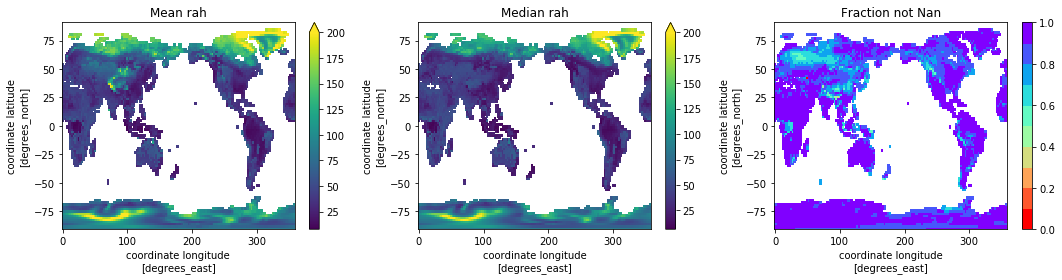

In [52]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
rah_ref.mean(dim='time').plot(vmax=200)
plt.title('Mean rah')
plt.subplot(1,3,2)
rah_ref.load().median(dim='time').plot(vmax=200)
plt.title('Median rah')
plt.subplot(1,3,3)
(1-np.isnan(rah_ref).sum(dim='time')/np.size(rah_ref.time)).where(~np.isnan(landfrac)).plot(vmax=1, vmin=0,
                                                                                          cmap=plt.cm.get_cmap("rainbow_r",10))
plt.title('Fraction not Nan')
plt.tight_layout()

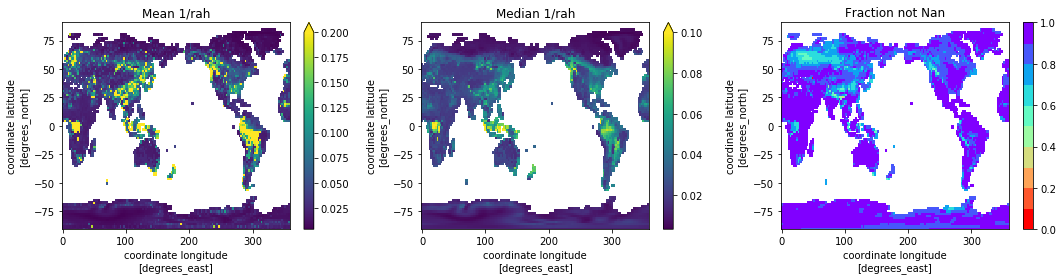

In [53]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
(1/rah_ref).mean(dim='time').plot(vmax=0.2)
plt.title('Mean 1/rah')
plt.subplot(1,3,2)
(1/rah_ref).load().median(dim='time').plot(vmax=0.1)
plt.title('Median 1/rah')
plt.subplot(1,3,3)
(1-np.isnan(rah_ref).sum(dim='time')/np.size(rah_ref.time)).where(~np.isnan(landfrac)).plot(vmax=1, vmin=0,
                                                                                          cmap=plt.cm.get_cmap("rainbow_r",10))
plt.title('Fraction not Nan')
plt.tight_layout()

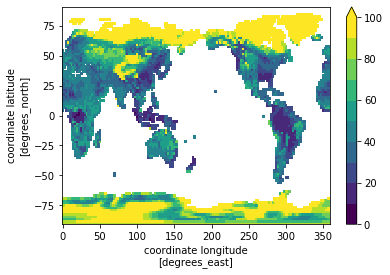

In [62]:
rah_ref_mean.plot(vmin=0,vmax=100,cmap=plt.get_cmap('viridis',10))

### Calculate rs

In [54]:
def calculate_ra(Ta, Ts, qa, p, SH):
    rho = calculate_rho(P, Ta, qa)
    SH_filtered=SH.where(np.abs(SH)>5)
    Tdiff=Ts-Ta
    Tdiff_filtered=Tdiff.where(np.abs(Tdiff)>0.1)
    return Cp*rho*(Tdiff_filtered/SH_filtered)

def calculate_rs(Ts, Ta, qa, LH, ra, P, Lv=CONSTANT_Lv):
    """
    rho= air density (kg/(m^3)
    Lv = latent heat of vaporization (J/kg)
    qdiff = kg/kg - kg/kg
    LH = W/m2
    ra=s/m
    
    output: s/m
    """
    rho = calculate_rho(P, Ta, qa)
    qsat_Ts = calculate_qsat(Ts, P)
    LH_filtered=LH.where(np.abs(LH)>5)
    qdiff=(qsat_Ts-qa)
    qdiff_filtered=qdiff.where(qdiff>0.001)
    return ((rho*Lv*qdiff_filtered)/LH_filtered)-ra

In [55]:
rah_ref_unfiltered=calculate_rah_simple(met_ref, Ts_ref, SH_ref)
raw_ref_unfiltered=calculate_raw_simple(met_ref, Ts_ref, LH_ref)
rs_ref_unfiltered=raw_ref_unfiltered-rah_ref_unfiltered
#ra_ref_unfiltered=ra_ref_unfiltered.where(ra_ref_unfiltered>0)
#rs_ref_unfiltered=raw_ref_unfiltered-ra_ref_unfiltered
#rs_ref_unfiltered=rs_ref_unfiltered.where(rs_ref_unfiltered>0)

#rah_ref=rah_ref.where((rah_ref_unfiltered>0)&(rah_ref_unfiltered<=1000))
raw_ref=raw_ref_unfiltered.where(raw_ref_unfiltered>0)
rs_ref=raw_ref-rah_ref
rs_ref=rs_ref.where(rs_ref>0)

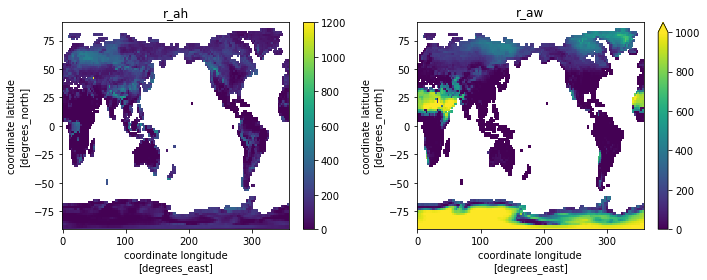

In [56]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
np.isnan(rah_ref).sum(dim='time').where(~np.isnan(landfrac)).plot()
plt.title('r_ah')
plt.subplot(1,2,2)
np.isnan(raw_ref).sum(dim='time').where(~np.isnan(landfrac)).plot(vmax=1000)
plt.title('r_aw')
plt.tight_layout()

# Calculate changes in resistances

In [108]:
### Load simulation data

output_dir='/glade/work/czarakas/Lague_kernels/TRM/'

key_short_list=['OFFL0007']##'OFFL0001','OFFL0002','OFFL0003','OFFL0004','OFFL0005','OFFL0006', 
                #'OFFL0007','OFFL0008','OFFL0009','OFFL0010','OFFL0011','OFFL0012',
                #'OFFL0013','OFFL0014','OFFL0015','OFFL0016','OFFL0017','OFFL0018',
                #'OFFL0019','OFFL0020','OFFL0021','OFFL0022','OFFL0023','OFFL0024',
                #'OFFL0025','OFFL0026','OFFL0027','OFFL0028','OFFL0029','OFFL0030',
                #'OFFL0031','OFFL0032','OFFL0033','OFFL0034','OFFL0035','OFFL0036']

for key_short in key_short_list[0:1]:

    key=key_short+'_PI_v02'
    desc=(crosswalk.description.values[(crosswalk.key_landonlyPPE.values==key_short)])[0]
    ensemble_dir='offline_simulations'
    
    #key=key_short+'_PI_SOM_v02'
    #desc=(crosswalk.description.values[(crosswalk.key_coupledPPE.values==key_short)])[0]
    #ensemble_dir='coupled_simulations'

    ###---------------- Get data
    print(key+': '+desc)

    [met, met_seasonal, LH, SH, Ts, FSA, FIRA, FIRE]=get_data(key, ensemble_dir='offline_simulations')
    met.Ta=met_ref.Ta
    met.calculate_other_params()

    ###---------------- Calculate deltas
    print('>> Calculating raw and rah')
    raw=calculate_raw_simple(met, Ts, LH)
    rah=calculate_rah_simple(met, Ts, SH)
    rs=raw
    
    
    ###---------------- Saving output
    """
    #print('>> Saving output')
    delta_Rnet_avg.to_dataset(name='delta_Rnet_avg').to_netcdf(output_dir+'delta_Rnet_avg.'+key+'.nc')
    delta_ra_avg.to_dataset(name='delta_ra_avg').to_netcdf(output_dir+'delta_ra_avg.'+key+'.nc')
    delta_rs_avg.to_dataset(name='delta_rs_avg').to_netcdf(output_dir+'delta_rs_avg.'+key+'.nc')
    delta_Ts_avg.to_dataset(name='delta_Ts_avg').to_netcdf(output_dir+'delta_Ts_avg.'+key+'.nc')
    dTs_Rnet_avg.to_dataset(name='dTs_Rnet_avg').to_netcdf(output_dir+'dTs_Rnet_avg.'+key+'.nc')
    dTs_ra_avg.to_dataset(name='dTs_ra_avg').to_netcdf(output_dir+'dTs_ra_avg.'+key+'.nc')
    dTs_rs_avg.to_dataset(name='dTs_rs_avg').to_netcdf(output_dir+'dTs_rs_avg.'+key+'.nc')
    dTs_est_avg.to_dataset(name='dTs_est_avg').to_netcdf(output_dir+'dTs_est_avg.'+key+'.nc')
    dTs_actual_avg.to_dataset(name='dTs_actual_avg').to_netcdf(output_dir+'dTs_actual_avg.'+key+'.nc')
    error_avg.to_dataset(name='error_avg').to_netcdf(output_dir+'error_avg.'+key+'.nc')
    """

OFFL0007_PI_v02: d_max, min
>> Calculating raw and rah


In [109]:
rah=calculate_rah_simple(met, Ts, SH,filter_on=True)
raw=calculate_raw_simple(met, Ts, LH,filter_on=True)
rs=raw-rah
rs=rs.where(rs>0)

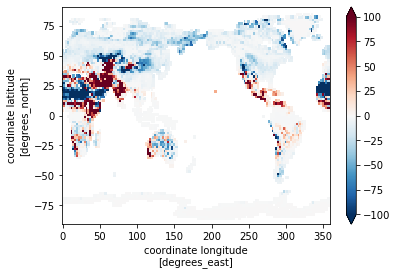

In [110]:
(rs-rs_ref).mean(dim='time').plot(vmax=100)

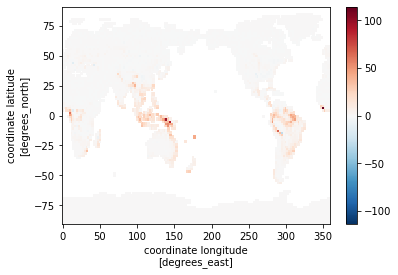

In [106]:
(rah-rah_ref).mean(dim='time').plot()

In [ ]:
rs=raw.mean(dim='time')-rah
rs_ref=raw_ref.mean(dim='time')-rah_ref

delta_Ts=Ts[spin_up_yr*12:,:,:].mean(dim='time')-Ts_ref.mean(dim='time')

delta_rah=(rah-rah_ref).load()
delta_raw=(raw.mean(dim='time')-raw_ref.mean(dim='time')).load()
delta_rs=(rs-rs_ref).load()

In [ ]:
plt.figure(figsize=(13,3))
plt.subplot(1,4,1)
delta_Ts.plot(vmax=1)
plt.title('dTs')

plt.subplot(1,4,2)
delta_rah.plot(vmax=20)
plt.title('drah')
plt.subplot(1,4,3)
delta_raw.plot(vmax=20)
plt.title('draw')
plt.subplot(1,4,4)
delta_rs.plot(vmax=20)
plt.title('drs')

plt.tight_layout()

# X

In [ ]:
fpath_kernels='/glade/work/czarakas/coupled_PPE/data/Lague_kernels/'

In [17]:
(rs_ref).plot(vmax=100)

NameError: name 'rs_ref' is not defined

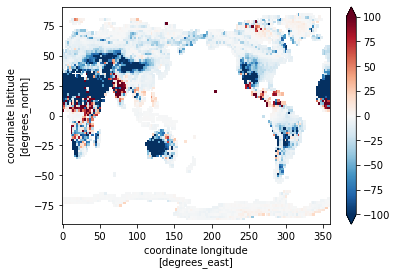

In [46]:
(raw.mean(dim='time')-raw_ref.mean(dim='time')).plot(vmax=100)

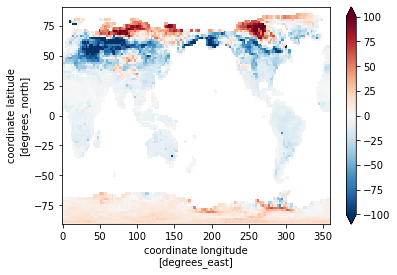

In [44]:
(rah-rah_ref).plot(vmax=100)

In [287]:
delta_rs=rs-rs_avg

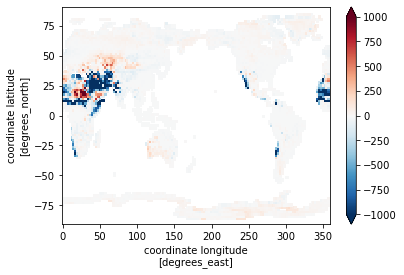

In [292]:
delta_rs.mean(dim='month').plot(vmax=1000)

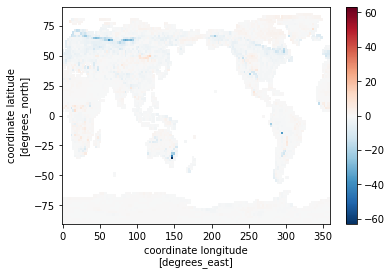

In [286]:
delta_rah.plot()

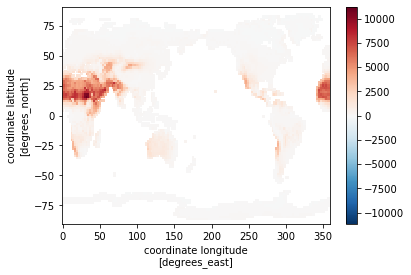

In [277]:
rs.mean(dim='time').plot()

In [232]:

#qdiff=qsat_Ts-met_ref.qa
#qdiff=VPD2M_ref*0.622/met_ref.P




In [233]:
##raw_combo_monthly=raw_combo.groupby('time.month').mean(dim='time')
#raw_counts=raw_combo.groupby('time.month').count(dim='time')
#ra_ref_monthly=ra_ref.groupby('time.month').mean(dim='time')
#ra_counts=ra_ref.groupby('time.month').count(dim='time')

#rs_avg_monthly=raw_combo_monthly-ra_ref_monthly

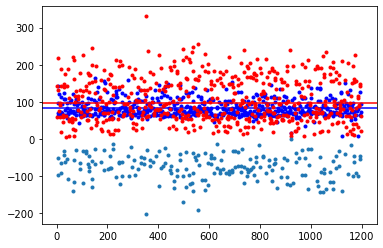

In [189]:
plt.plot(raw_combo[:,70+13, 30],'.b')
plt.axhline(np.nanmean(raw_combo[:,70+13, 30]),color='b')
plt.plot(ra_ref.where(ra_ref>0)[:,70+13, 30],'.r')
plt.axhline(np.nanmean(ra_ref[:,70+13, 30]),color='r')
plt.plot(raw_sub[:,70+13, 30]-
        ra_ref.where(ra_ref>0)[:,70+13, 30],'.')

In [209]:
raw_sub[:,70+13, 30].mean(dim='time').values

array(96.00892, dtype=float32)

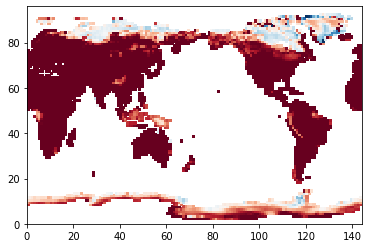

In [207]:
plt.pcolormesh(rs_avg,vmax=100,vmin=-100,
               cmap=plt.cm.RdBu_r)

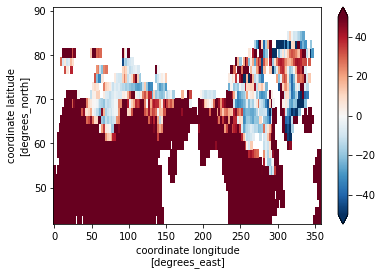

In [208]:
(rs_avg[70:,:]).plot(vmax=50)

In [156]:
i=74
j=112

i=80#86
j=110#128

In [157]:
RHS=met_ref.rho*SHR_CONST_LATSUB*(qsat_Ts-met_ref.qa)
RHS_ij=RHS[:,i,j].load()

In [158]:
ra_ij=ra_ref[:,i,j].load()
raw_sub_ij=raw_sub[:,i,j].load()
rs_ij_avg=raw_ij.mean(dim='time')-ra_ij.mean(dim='time')

raw_ij=raw[:,i,j].load()
raw_ij_avg=raw_ij.mean(dim='time')

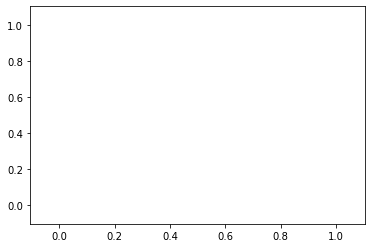

In [159]:
plt.plot(raw_ij,'.')
plt.plot(ra_ij,'.r')
plt.axhline(raw_ij_avg)
plt.axhline(np.nanmean(ra_ij),color='r')
plt.axhline(np.nanmedian(raw_ij))

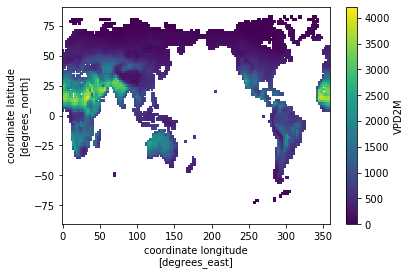

In [139]:
VPD2M.mean(dim='time').plot()

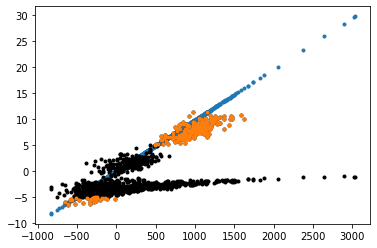

In [122]:
plt.plot(RHS_ij,
         LH_pred,'.')
plt.plot(RHS_ij,
         LH_ref[:,i,j],'.k')
plt.plot(RHS_ij,
         LH_ref[:,i,j].where(np.abs(LH_ref[:,i,j])>5),'.') 

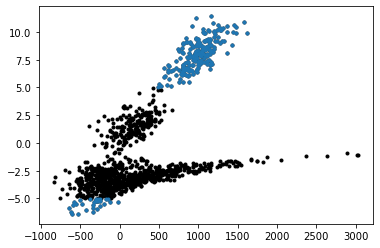

In [115]:

plt.plot(RHS[:,i,j],
         LH_ref[:,i,j],'.k')
plt.plot(RHS[:,i,j],
         LH_ref[:,i,j].where(np.abs(LH_ref[:,i,j])>5),'.')       

In [107]:
rs_avg=raw.mean(dim='time')-ra_ref.mean(dim='time')

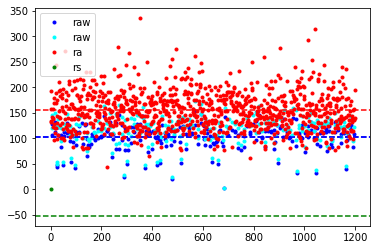

In [125]:
plt.plot(raw_ij,'.b', label='raw')
plt.axhline(y=np.nanmean(raw_ij),linestyle='--',color='b')
plt.plot(raw_sub_ij,'.',color='aqua', label='raw')
plt.axhline(y=np.nanmean(raw_ij),linestyle='--',color='b')
plt.plot(ra_ij,'.r', label='ra')
plt.axhline(y=np.nanmean(ra_ij),linestyle='--',color='r')
plt.plot(rs_ij,'.g',label='rs')
plt.axhline(y=rs_ij_avg,linestyle='--',color='g')
plt.legend()

In [102]:
CONSTANT_Lv

2501000.0

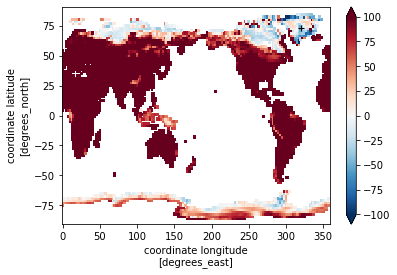

In [101]:
rs_avg.plot(vmax=100)
plt.plot(raw.lon[j],raw.lat[i],'+k')

In [309]:
output_dir='/glade/work/czarakas/Lague_kernels/TRM/'

for i,key_short in enumerate(crosswalk.key_landonlyPPE.values):
    print(key_short)
    key=key_short+'_PI_v02'
    
    desc=(crosswalk.description.values[(crosswalk.key_landonlyPPE.values==key_short)])[0]
    print(key+': '+desc)
    
    [met, met_seasonal, LH, SH, Ts, FSA, FIRA, FIRE]=get_data(key,ensemble_dir='offline_simulations')
    met.Ta=met_ref.Ta

    met.calculate_other_params()
    ra_est=met.rho*CONSTANT_Cp*(Ts-met.Ta)/SH.where(np.abs(SH)>5)
    
    ra_est_avg=ra_est[40:,:,:].mean(dim='time')
    
    
    ra_avg_delta=(ra_est_avg-ra_ref_avg)
    ds_ra_avg_delta=ra_avg_delta.to_dataset('delta_ra_avg')
    
    ds_ra_avg_delta.to_netcdf(output_dir+'delta_ra_annual_avg.'+key+'.nc')

OFFL0001
OFFL0001_PI_v02: rhosnir, min
OFFL0002
OFFL0002_PI_v02: rhosnir, max
OFFL0007
OFFL0007_PI_v02: d_max, min
OFFL0008
OFFL0008_PI_v02: d_max, max
OFFL0009
OFFL0009_PI_v02: frac_sat_soil_dsl_init, min
OFFL0010
OFFL0010_PI_v02: frac_sat_soil_dsl_init, max
OFFL0013
OFFL0013_PI_v02: maximum_leaf_wetted_fraction, min
OFFL0014
OFFL0014_PI_v02: maximum_leaf_wetted_fraction, max
OFFL0015
OFFL0015_PI_v02: fff, min
OFFL0016
OFFL0016_PI_v02: fff, max
OFFL0017
OFFL0017_PI_v02: upplim_destruct_metamorph, min
OFFL0018
OFFL0018_PI_v02: upplim_destruct_metamorph, max
OFFL0019
OFFL0019_PI_v02: medlynslope, max
OFFL0020
OFFL0020_PI_v02: medlynintercept, min
OFFL0021
OFFL0021_PI_v02: tpu25ratio, min
OFFL0022
OFFL0022_PI_v02: tpu25ratio, max
OFFL0023
OFFL0023_PI_v02: jmaxb0, max
OFFL0024
OFFL0024_PI_v02: jmaxb1, min
OFFL0025
OFFL0025_PI_v02: jmaxb1, max
OFFL0026
OFFL0026_PI_v02: kmax, min
OFFL0027
OFFL0027_PI_v02: kmax, max
OFFL0028
OFFL0028_PI_v02: nstem, min
OFFL0029
OFFL0029_PI_v02: nstem, max
OF

In [84]:
no_vals=(~np.isnan(rs_ref)).sum(dim='time').where(~np.isnan(met.Ta[0,:,:])).load()#.plot()
#(~np.isnan(rs_ref)).sum(dim='time').plot()

In [85]:
threshold=0.15*1680

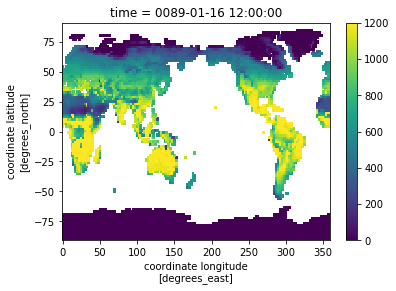

In [86]:
no_vals.plot()

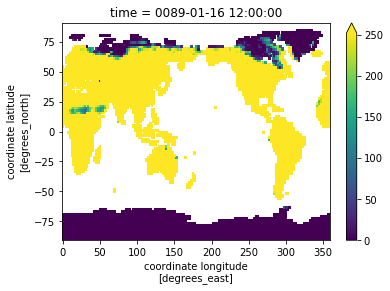

In [87]:
no_vals.plot(vmax=threshold)

In [51]:
delta_SWabs=FSA[12*60:,:,:].mean(dim='time')-FSA_ref[12*60:,:,:].mean(dim='time')

In [117]:
htop=get_dataset(ensemble_dir='offline_simulations',var='HTOP', key=key)['HTOP']
htop_ref=get_dataset(ensemble_dir='offline_simulations',var='HTOP', key=key_ref)['HTOP']
htop_delta=htop-htop_ref

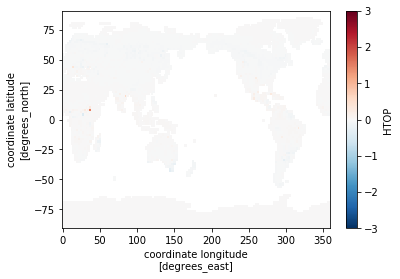

In [118]:
htop_delta.mean(dim='time').plot(vmin=-3, vmax=3, cmap=plt.cm.RdBu_r)

In [89]:
EF=LH.where(np.abs(LH)>5)/(LH+SH.where(np.abs(SH)>5)).where(ds_Ta>273.15+5)
EF_ref=LH_ref.where(np.abs(LH_ref)>5)/(LH_ref+SH_ref.where(np.abs(SH_ref)>5)).where(ds_Ta_ref>273.15+5)

In [90]:
delta_EF=EF-EF_ref
delta_EF_mean=delta_EF.mean(dim='time').load()
delta_EF_mean_of_means=EF.mean(dim='time').load()-EF_ref.mean(dim='time').load()

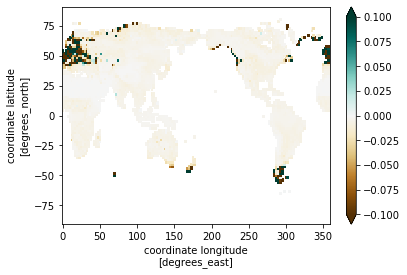

In [91]:
delta_EF_mean_of_means.plot(vmin=-0.1, vmax=0.1, cmap=plt.cm.BrBG)

In [92]:
print(1)

1


In [94]:
prefix=1/(4*emissivity_ref*CONSTANT_sigma*(Ts**3))
delta_albedo=albedo-albedo_ref
dTs_from_albedo=-prefix*met_ref.SWin*delta_albedo

In [104]:
dTs_from_albedo_mean=dTs_from_albedo.mean(dim='time').load()

In [98]:
not_albedo=dTs_actual-dTs_from_albedo.mean(dim='time')#.plot()

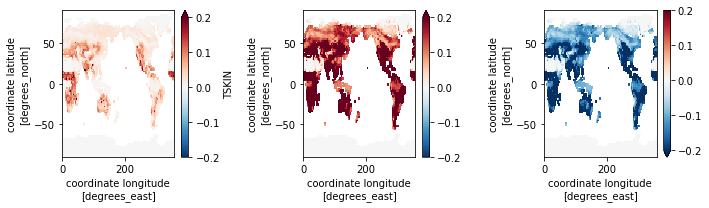

In [107]:
vmin=-0.3
vmax=0.3
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
dTs_actual.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.subplot(1,3,2)
dTs_from_albedo_mean.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.subplot(1,3,3)
not_albedo.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.tight_layout()